In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import xgboost as xgb
import scipy.stats as stats
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from hyperopt import hp, fmin, tpe, Trials

In [21]:
df = pd.read_csv('../../../data/day_ahead_energy_prices.csv', delimiter=",")
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

df = df[::-1]

df.rename(columns={"hourly day-ahead energy price": "Price"}, inplace=True)

In [22]:
SPLIT_DATE = df.index[int(0.18 * len(df))]


train = df.loc[df.index < SPLIT_DATE]
initial_test = df.loc[df.index >= SPLIT_DATE]


test_val_split = int(len(initial_test) / 2)

test = initial_test.iloc[:test_val_split]
val = initial_test.iloc[test_val_split:]

val

,Price
Datetime,
2024-05-04 00:00:00,90.80
2024-05-03 23:00:00,85.56
2024-05-03 22:00:00,93.46
2024-05-03 21:00:00,107.95
2024-05-03 20:00:00,119.94
...,...
2023-10-15 05:00:00,7.63
2023-10-15 04:00:00,5.72
2023-10-15 03:00:00,9.06


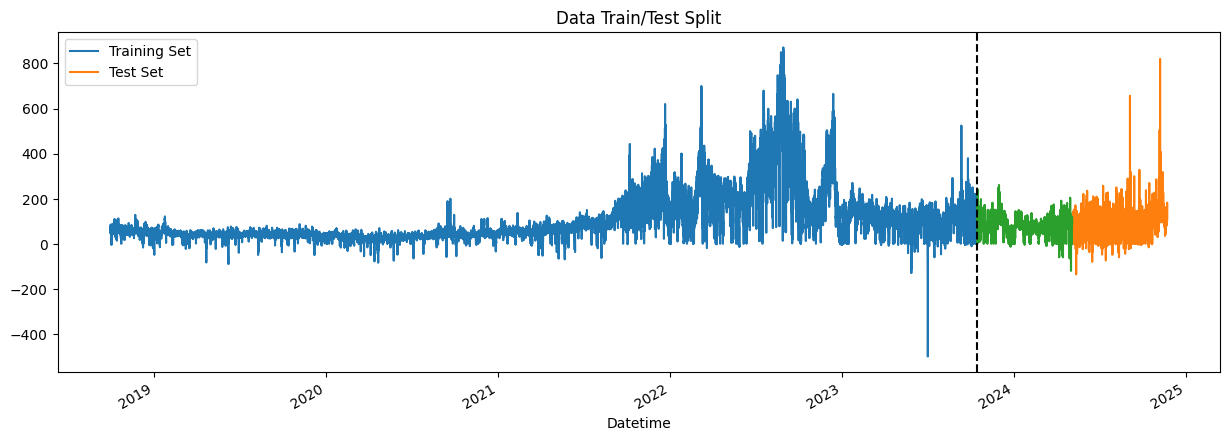

In [23]:
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
val.plot(ax=ax, label='Evaluation Set')
ax.axvline(SPLIT_DATE, color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [24]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week

    for window in [3, 6, 12]: # hours
        df[f'ma_{int(window)}_hours'] = df['Price'].rolling(window=window).mean()
    
    for window in [24, 72, 168]:  # 1 day 3 days, and 1 week
        df[f'ma_{int(window / 24)}_days'] = df['Price'].rolling(window=window).mean()

    return df

df = create_features(df)
df

,Price,hour,dayofweek,dayofyear,weekofyear,ma_3_hours,ma_6_hours,ma_12_hours,ma_1_days,ma_3_days,ma_7_days
Datetime,,,,,,,,,,,
2024-11-21 23:00:00,107.46,23,3,326,47,NaN,NaN,NaN,NaN,NaN,NaN
2024-11-21 22:00:00,122.90,22,3,326,47,NaN,NaN,NaN,NaN,NaN,NaN
2024-11-21 21:00:00,123.05,21,3,326,47,117.803333,NaN,NaN,NaN,NaN,NaN
2024-11-21 20:00:00,131.33,20,3,326,47,125.760000,NaN,NaN,NaN,NaN,NaN
2024-11-21 19:00:00,154.05,19,3,326,47,136.143333,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2018-10-01 04:00:00,47.59,4,0,274,40,56.110000,68.363333,65.673333,59.686667,40.311806,51.385298
2018-10-01 03:00:00,47.38,3,0,274,40,48.860000,63.000000,65.205000,59.837083,40.318750,51.385655
2018-10-01 02:00:00,51.41,2,0,274,40,48.793333,57.406667,64.807500,60.143333,40.399444,51.393095


In [25]:
train = create_features(train)
test = create_features(test)
val = create_features(val)

FEATURES = ['hour', 'dayofyear', 'dayofweek', 'ma_3_hours','ma_6_hours','ma_1_days','ma_3_days','ma_7_days']
TARGET = 'Price'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

X_val = val[FEATURES]
y_val = val[TARGET]



In [13]:
model = xgb.XGBRegressor()

In [26]:
# param_grid = {
#     "learning_rate": [0.01, 0.05, 0.15, 0.2, 0.3],
#     "base_score": [0.5, 0.6, 0.7,0.8,0.9,1],
#     "n_estimators": [100, 200, 300, 500, 750, 1000],
#     "early_stopping_rounds": [10, 25, 50, 75, 100],
#     "max_depth": [3,5,7,10]
#  }

# search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1)


param_dist = {
    "learning_rate": stats.uniform(0.01, 0.3),  # Continuous, no need for int
    "base_score": stats.uniform(0.5, 0.5),      # Continuous, range 0.5 to 1
    "n_estimators": stats.randint(100, 1001),   # Integer range, 100 to 1000
    "early_stopping_rounds": stats.randint(10, 101),  # Integer range, 10 to 100
    "max_depth": stats.randint(3, 11)           # Integer range, 3 to 10
}

# run randomized search
# n_iter_search = 15
# search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=n_iter_search, cv=5, n_jobs=-1)
# search.fit(
#     X_train, y_train,
#     eval_set=[(X_test, y_test)], 
#     verbose=True,
# )

# print("Best parameters found: ", search.best_params_)

In [27]:
space = {
    'base_score': hp.uniform('base_score', 0.1, 0.9),
    'early_stopping_rounds': hp.choice('early_stopping_rounds', [10, 20, 30, 50, 70, 100]),
    'max_depth': hp.choice('max_depth', [2,3,4, 5, 7, 9, 11, 13, 15, 20, 25]),
    'learning_rate': hp.loguniform('learning_rate', 0.001, 0.5),
    'n_estimators': hp.choice('n_estimators', [100, 300, 350, 400, 500, 1000, 10]),
    'gamma': hp.uniform('gamma', 0, 1),
    'min_child_weight': hp.choice('min_child_weight', [0.1, 1, 5, 10, 20]),
    'subsample': hp.uniform('subsample', 0.1, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1.0),
}

# Keeping track of the optimization history
trials = Trials()

def objective(params):

    model = xgb.XGBRegressor(
        base_score=params['base_score'],
        early_stopping_rounds=params['early_stopping_rounds'],
        max_depth=params['max_depth'],
        learning_rate=params['learning_rate'],
        n_estimators=params['n_estimators'],
        gamma=params['gamma'],
        min_child_weight=params['min_child_weight'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        objective='reg:squarederror',
    )
    
    # Fit the model on the training data
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],  # Provide validation set for early stopping
        verbose=False  # Suppress training output
    )
    
    # Predict on the validation set
    predictions = model.predict(X_test)
    
    # Calculate the root mean squared error (RMSE)
    rmse = root_mean_squared_error(y_test, predictions)
    
    return rmse

# Run the Hyperopt optimization
best = fmin(
    fn=objective,            # Objective function
    space=space,             # Hyperparameter space
    algo=tpe.suggest,        # Optimization algorithm
    max_evals=50,            # Number of trials
    trials=trials,           # Store trials history
)

# Display best parameters
print("Best hyperparameters:", best)

# Extract the best hyperparameters
best_params = {
    'base_score': best['base_score'],
    'early_stopping_rounds': best['early_stopping_rounds'],
    'max_depth': best['max_depth'],
    'learning_rate': best['learning_rate'],
    'n_estimators': best['n_estimators'],
    'colsample_bytree': best['colsample_bytree'],
    'gamma': best['gamma'],
    'subsample': best['subsample'],
    'min_child_weight':best['min_child_weight'],
}

# Train the final model with the best hyperparameters on the full dataset
final_model = xgb.XGBRegressor(
    base_score=best_params['base_score'],
    early_stopping_rounds=best_params['early_stopping_rounds'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    n_estimators=best_params['n_estimators'],
    gamma=best_params['gamma'],
    min_child_weight=best_params['min_child_weight'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    objective='reg:squarederror',
)

final_model.fit(X_train, y_train,  eval_set=[(X_test, y_test)])

# Predict on the test set or validation set
final_predictions = final_model.predict(X_test)
final_rmse = root_mean_squared_error(y_test, final_predictions)
print("Final model RMSE:", final_rmse)


100%|██████████| 50/50 [00:18<00:00,  2.72trial/s, best loss: 17.250137792248424]
Best hyperparameters: {'base_score': np.float64(0.6880643012958115), 'colsample_bytree': np.float64(0.7165197355751676), 'early_stopping_rounds': np.int64(2), 'gamma': np.float64(0.999533123117512), 'learning_rate': np.float64(1.1424316371261474), 'max_depth': np.int64(1), 'min_child_weight': np.int64(2), 'n_estimators': np.int64(5), 'subsample': np.float64(0.8336842294498906)}
[0]	validation_0-rmse:51.87494
[1]	validation_0-rmse:58.14586
[2]	validation_0-rmse:51.22036
[3]	validation_0-rmse:35.84006
[4]	validation_0-rmse:35.88251
Final model RMSE: 35.84005645136339


autml gridsearch autoscikit-learn